[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MusicalInformatics/miws23/blob/main/key_meter/meter_estimation.ipynb)

In [21]:
import os
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install dependencies
    ! pip install python-hiddenmarkov
    ! pip install ipympl
    ! pip install partitura

    # Enable interactive plots in colab
    from google.colab import output
    output.enable_custom_widget_manager()

    # To be able to access helper modules in the repo for this tutorial
    # (not necessary if the jupyter notebook is run locally instead of google colab)
    !git clone https://github.com/MusicalInformatics/miws23
    import sys
    sys.path.insert(0, "/content/miws23/key_meter/")

# Meter and Tempo Estimation on Symbolic Music

Meter, time signature, beat, downbeat, and tempo estimation form a group of related tasks. At first glance, many of them might seem trivial on symbolic music, after all the precise onsets of notes are known from the MIDI data. But with changing tempi and unknown measures it can be quite challenging! 

In [22]:
# Let's import some stuff
%matplotlib widget
from typing import Union, Tuple, Iterable

import partitura as pt
from partitura.performance import PerformanceLike
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from meter_estimation_utils import NOTEBOOK_DIR

import warnings
warnings.filterwarnings("ignore")



%config InlineBackend.figure_format ='retina'

## Data Exploration

Before describing the methods for computing metrical and tempo information, let's do some data exploration!

In [23]:
# load piece
path_to_match = os.path.join(NOTEBOOK_DIR, "example_data", "mozart_k265_var1.match")
performance, alignment, score = pt.load_match(path_to_match, create_score=True)
ppart = performance[0]
note_array = performance.note_array()

note_array_score = score.note_array(include_time_signature=True)

# We assume that there is just a single time signature throughout the piece
time_signature = note_array_score[["ts_beats", "ts_beat_type"]][0]
target_meter = time_signature["ts_beats"]
print(time_signature)

(2, 4)


Let's compute the tempo of this performance from the alignment information.

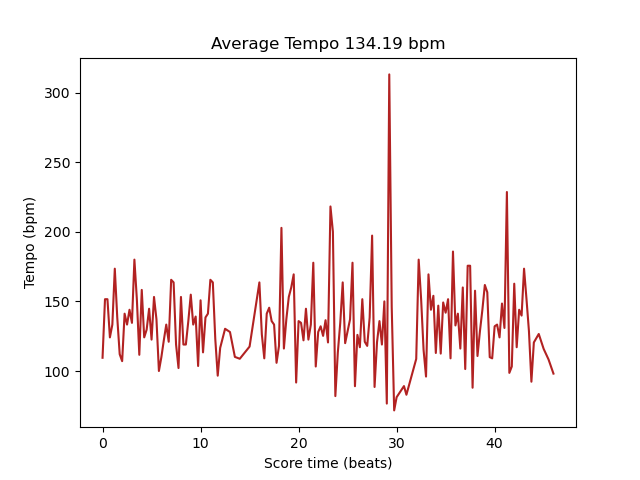

In [24]:
(
    ptime_to_stime_map,
    stime_to_ptime_map,
) = pt.musicanalysis.performance_codec.get_time_maps_from_alignment(
    ppart_or_note_array=note_array,
    spart_or_note_array=note_array_score,
    alignment=alignment,
)

# unique score onsets
s_onsets = np.unique(note_array_score["onset_beat"])
# aggregated performed onsets
p_onsets = stime_to_ptime_map(s_onsets)

tempo_curve = 60 * np.diff(s_onsets) / np.diff(p_onsets)
target_tempo = tempo_curve.mean()
fig, ax = plt.subplots()
ax.plot(s_onsets[:-1], tempo_curve, color="firebrick")
ax.set_xlabel("Score time (beats)")
ax.set_ylabel("Tempo (bpm)")
ax.set_title(f"Average Tempo {tempo_curve.mean():.2f} bpm")

plt.show()

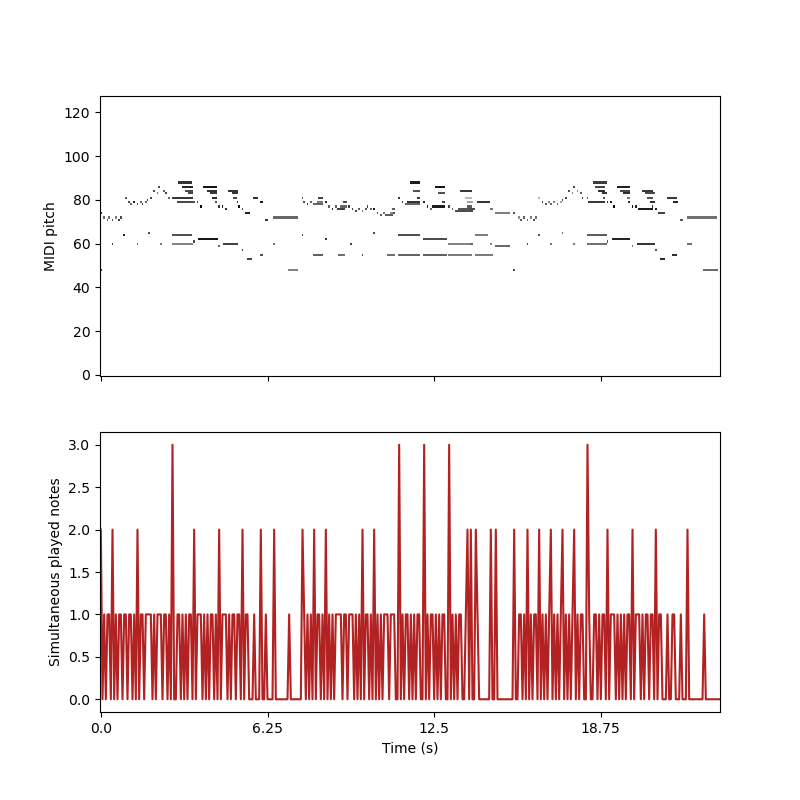

In [25]:
time_div = 16
# Piano roll
piano_roll = pt.utils.music.compute_pianoroll(
    note_info=note_array,
    time_unit="sec",
    time_div=time_div,
    note_separation=True,
).toarray()

# Frames of the piano roll with onsets (velocity is added)
frames_nq = (
    pt.utils.music.compute_pianoroll(
        note_info=note_array,
        time_unit="sec",
        time_div=time_div,
        onset_only=True,
        binary=True,  # Count number of notes, instead of velocity
    )
    .toarray()
    .sum(0)
)
#
# frames_nq[frames_nq != 0] = 1

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    sharex=True,
)
ax[0].imshow(
    piano_roll,
    origin="lower",
    aspect="auto",
    cmap="binary",
    interpolation="nearest",
)
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("MIDI pitch")
ax[1].set_ylabel("Simultaneous played notes")
ax[1].set_xticks(
    np.arange(0, len(frames_nq), 100),
    np.arange(0, len(frames_nq), 100) / time_div,
)
ax[1].plot(frames_nq, color="firebrick")
plt.show()

### Data Exploration - 1

Let's have a look at the distribution of inter onset intervals!

138.92913928101072


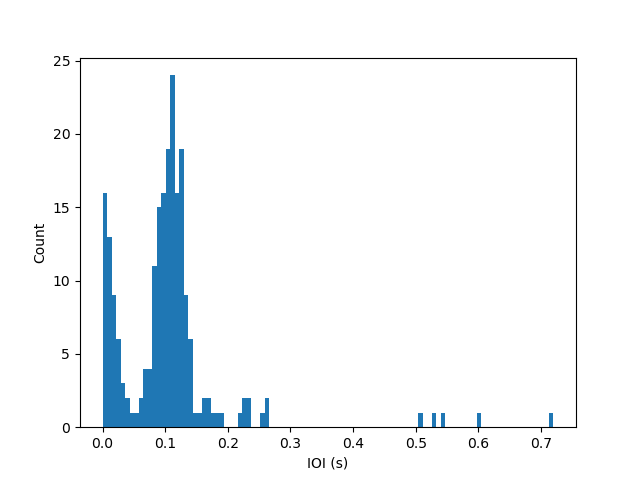

In [26]:
IOIs = np.diff(np.sort(note_array["onset_sec"]))
hist, bins = np.histogram(IOIs, bins=100)

print(60 / (4 * bins[np.argmax(hist)]))
fig, ax = plt.subplots()
ax.hist(IOIs, bins=bins)
ax.set_xlabel("IOI (s)")
ax.set_ylabel("Count")
plt.show()

### Data Exploration - 2

There are many small inter onset intervals from musical notes that are played "simultaneously". For the task at hand, the spread or local deviations are not of interest, on the other hand, we would like to derive a common onset from notes that are notated in the same score position. Let's give it a try by converting the measured onsets to a framed unidimensional signal that contains the number of onsets in a performance in a small window in time, e.g. 20 ms

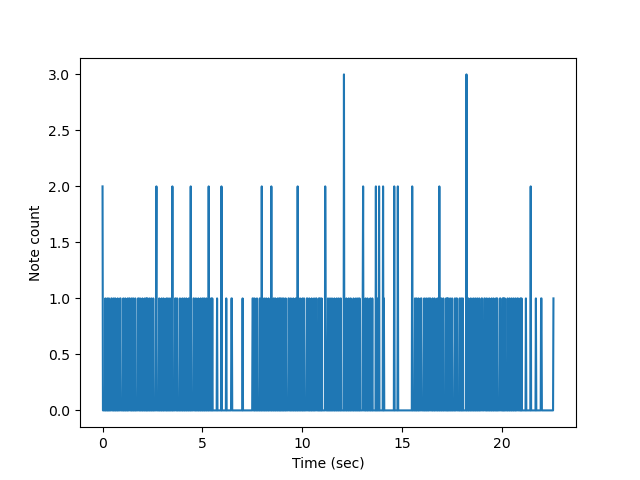

In [27]:
FRAMERATE = 50

onset_min = note_array["onset_sec"].min()
onset_max = note_array["onset_sec"].max()
onset_duration = onset_max - onset_min
frames = np.zeros(int(onset_duration * FRAMERATE) + 1)
for note in note_array:
    frames[int((note["onset_sec"] - onset_min) * FRAMERATE)] += 1

fig, ax = plt.subplots()
ax.plot(np.arange(len(frames)) / FRAMERATE, frames)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Note count")
plt.show()

### Data Exploration - 3

The previous aggregation is fairly noisy and for most cases does not give good results, reason being the arbitrary cutoff in onset times between the frames. Let's try different frame generation process that aggregates very close onsets and at the same time encodes dynamics / quantity

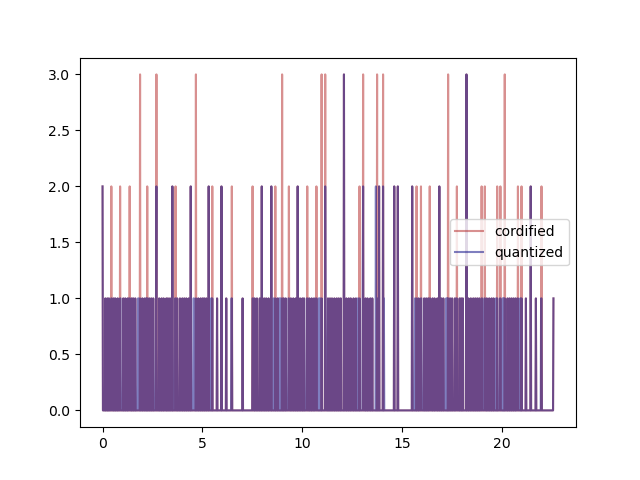

In [28]:
aggregated_notes = [(0, 0)]
CHORD_SPREAD_TIME = 1 / 12  # a little faster than 16th notes at 180 bpm

for note in ppart.notes:
    prev_note_on = aggregated_notes[-1][0]
    note_on = note["note_on"]
    prev_note_vel = aggregated_notes[-1][1]
    if abs(note_on - prev_note_on) < CHORD_SPREAD_TIME:
        aggregated_notes[-1] = (note_on, prev_note_vel + 1)
        # aggregated_notes[-1] = (note_on, prev_note_vel + note["velocity"])  # 1
    else:
        aggregated_notes.append((note_on, 1))  # 1
        # aggregated_notes.append((note_on, note["velocity"]))  # 1

frames_a = np.zeros(int(onset_duration * FRAMERATE) + 1)
for note in aggregated_notes:
    frames_a[int((note[0] - onset_min) * FRAMERATE)] += note[1]

frames_a[frames_a < 0.1] = 0.0

fig, ax = plt.subplots()
ax.plot(
    np.arange(len(frames)) / FRAMERATE,
    frames_a,
    label="cordified",
    color="firebrick",
    alpha=0.5,
)
ax.plot(
    np.arange(len(frames)) / FRAMERATE,
    frames,
    label="quantized",
    color="navy",
    alpha=0.5,
)

plt.legend(loc="best")

plt.show()

### Data Exploration - 4

Now that signal looks a lot more like approximately isochronous onsets, some with high velocity (sum of velocities occurring at this onset), some with lower. You can change the velocity to just a note count per onset to get an alternative onset value. 

One standard signal processing way of getting an estimate of the frequency of these onsets is to compute autocorrelation with increasing lag parameters. We plot the accumulated signal over time for different lag parameters to see at which lag the signal reinforces itself most strongly. How do we interpret these dimensions? The number of frames between onsets (= lag) is inversely proportional to the tempo of the onsets!

Besides visual analysis we can try some basic peak picking to get a numeric estimate of the frequency.

In [29]:
from meter_estimation_utils import compute_autocorrelation

autocorr = compute_autocorrelation(frames_nq)

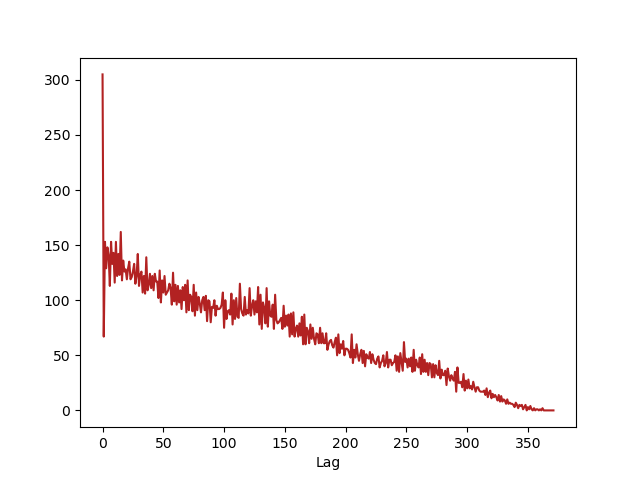

In [30]:
fig, ax = plt.subplots()
ax.plot(autocorr, color="firebrick")
ax.set_xlabel("Lag")
plt.show()

In [31]:
from scipy.signal import find_peaks

# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
a, _ = find_peaks(autocorr[1:], prominence=30)
m = np.argmax(autocorr[1:])
print(60 / ((a + 1) / time_div), 60 / ((m + 1) / time_div))

[480.         137.14285714  87.27272727  64.          26.66666667
   8.49557522   7.11111111   6.76056338] 64.0



## HMMs for Meter Estimation

Without more sophisticated methods it's hard to get a robust estimate of meter and tempo from this data.

A hidden model with a constant transition model and a state space encoding a measure in frames (1 measure = 100 states = 100 frames). The observation model produces onsets at states that encode 

In [32]:
from hiddenmarkov import HMM, ConstantTransitionModel, ObservationModel

FRAMERATE = 50

In [33]:
class MeterObservationModel(ObservationModel):
    def __init__(
        self,
        states: int = 100,
        downbeat_idx: Iterable = [0],
        beat_idx: Iterable = [50],
        subbeat_idx: Iterable = [25],
    ):
        super().__init__()
        self.states = states
        # observation 1 = note onset present, 0 = nothing present
        self.probabilities = np.ones((2, states)) / 100
        self.probabilities[0, :] = 0.99
        for idx in subbeat_idx:
            self.probabilities[:, idx] = [0.5, 0.5]
        for idx in beat_idx:
            self.probabilities[:, idx] = [0.3, 0.7]
        for idx in downbeat_idx:
            self.probabilities[:, idx] = [0.1, 0.9]
        self.db = downbeat_idx
        self.b = beat_idx
        self.sb = subbeat_idx

    def get_beat_states(self, state_sequence: np.ndarray) -> np.ndarray:
        state_encoder = np.zeros_like(state_sequence)
        for i, state in enumerate(state_sequence):
            if state in self.sb:
                state_encoder[i] = 1
            if state in self.b:
                state_encoder[i] = 2
            if state in self.db:
                state_encoder[i] = 3
        return state_encoder

    def __call__(self, observation: np.ndarray) -> np.ndarray:
        if not self.use_log_probabilities:
            return self.probabilities[observation, :]
        else:
            return np.log(self.probabilities[observation, :])


def getTransitionMatrix(states: int, distribution: Iterable = [0.1, 0.8, 0.1]):
    transition_matrix = (
        np.eye(states, k=0) * distribution[0]
        + np.eye(states, k=1) * distribution[1]
        + np.eye(states, k=2) * distribution[2]
        + np.ones((states, states)) / 1e7
    )
    transition_matrix[-2, 0] = distribution[2]
    transition_matrix[-1, 0] = distribution[2] + distribution[1]
    return transition_matrix

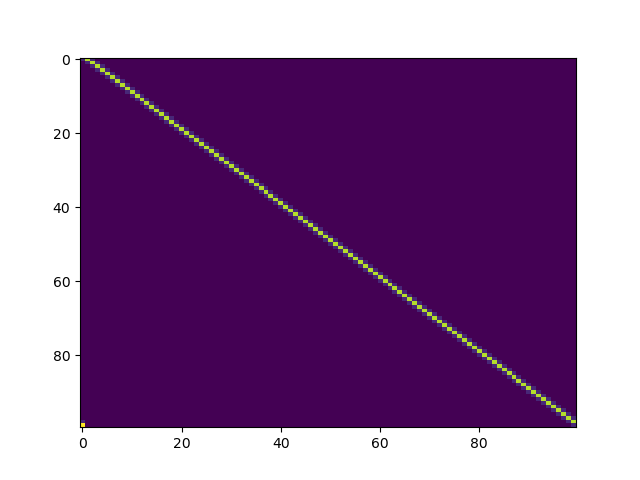

In [34]:
fig, ax = plt.subplots()

transition_matrix = getTransitionMatrix(states=100, distribution=[0.1, 0.8, 0.1])

ax.imshow(transition_matrix, aspect="auto")
plt.show()

In [35]:
def createHMM(
    tempo: float = 50,
    frame_rate: int = FRAMERATE,  # frames_per_beat
    beats_per_measure: int = 4,
    subbeats_per_beat: int = 2,
):
    frames_per_beat = 60 / tempo * frame_rate
    frames_per_measure = frames_per_beat * beats_per_measure
    states = int(frames_per_measure)
    downbeat_idx = [0]
    beat_idx = [int(states / beats_per_measure * k) for k in range(beats_per_measure)]
    subbeat_idx = [
        int(states / (beats_per_measure * subbeats_per_beat) * k)
        for k in range(beats_per_measure * subbeats_per_beat)
    ]

    observation_model = MeterObservationModel(
        states=states,
        downbeat_idx=downbeat_idx,
        beat_idx=beat_idx,
        subbeat_idx=subbeat_idx,
    )

    transition_matrix = getTransitionMatrix(states)
    transition_model = ConstantTransitionModel(transition_matrix)

    return observation_model, transition_model

In [36]:
observation_model, transition_model = createHMM(
    tempo=60,
    frame_rate=FRAMERATE,
    beats_per_measure=2,
    subbeats_per_beat=2,  # bpm
)

hmm = HMM(observation_model=observation_model, transition_model=transition_model)

frames_a[frames_a < 1.0] = 0
frames_a[frames_a >= 1.0] = 1

observations = np.array(frames_a, dtype=int)
path, log_lik = hmm.find_best_sequence(observations)

beat_states = observation_model.get_beat_states(path)

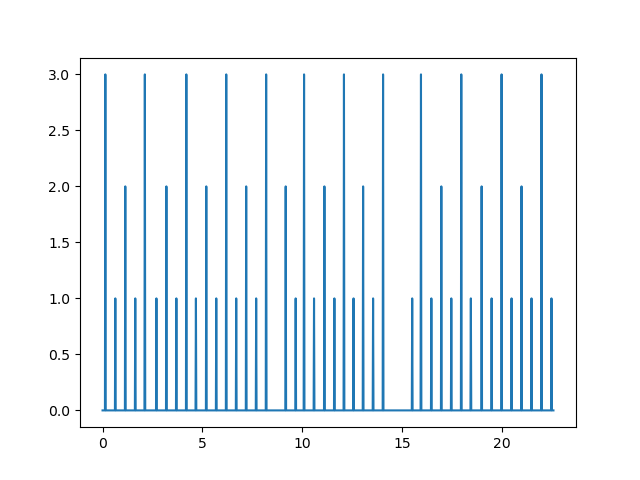

60.0


In [37]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(beat_states)) / FRAMERATE, beat_states)
plt.show()

beat_times = np.where(beat_states >= 2)[0] / FRAMERATE

print(np.median(60 / np.diff(beat_times)))

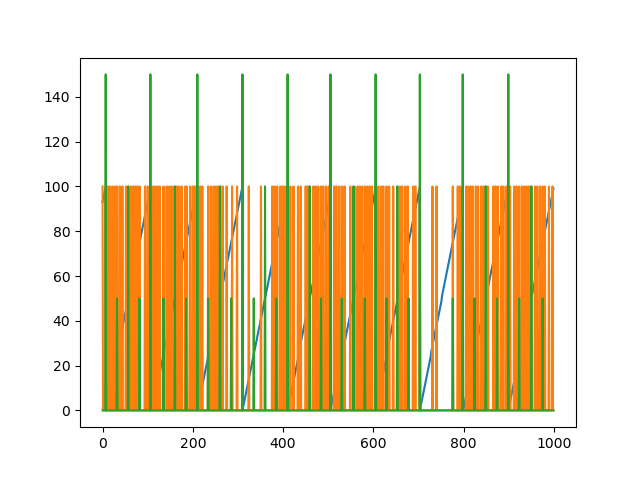

In [38]:
fig, ax = plt.subplots()
plt.plot(path[:1000])
plt.plot(observations[:1000] * 100)
ax.plot(observation_model.get_beat_states(path)[:1000] * 50)

Let's put everything together!

In [39]:
from meter_estimation_utils import get_frames_quantized, get_frames_chordify


def meter_identification(
    note_info: PerformanceLike,
    beats_per_measure: Iterable[int] = [2, 3, 4],
    subbeats_per_beat: Iterable[int] = [2, 3],
    tempi: Union[Iterable[int], str] = "auto",
    frame_aggregation: str = "chordify",
    value_aggregation: str = "num_notes",
    framerate: int = 50,
    frame_threshold: float = 0.0,
    chord_spread_time: float = 1 / 12,
    max_tempo: float = 250,
    min_tempo: float = 30,
) -> Tuple[int, float]:
    """
    Meter Identification using HMMs
    """
    # get note array
    note_array = pt.utils.ensure_notearray(note_info)

    if frame_aggregation == "chordify":
        frames = get_frames_chordify(
            note_array=note_array,
            framerate=framerate,
            chord_spread_time=chord_spread_time,
            aggregation=value_aggregation,
            threshold=frame_threshold,
        )
    elif frame_aggregation == "quantize":
        frames = get_frames_quantized(
            note_array=note_array,
            framerate=framerate,
            aggregation=value_aggregation,
            threshold=frame_threshold,
        )

    if tempi == "auto":
        autocorr = compute_autocorrelation(frames)
        beat_period, _ = find_peaks(autocorr[1:], prominence=20)
        tempi = 60 * framerate / (beat_period + 1)
        tempi = tempi[np.logical_and(tempi <= max_tempo, tempi >= min_tempo)]

    likelihoods = []

    for ts_num in beats_per_measure:
        for sbpb in subbeats_per_beat:
            for tempo in tempi:
                observation_model, transition_model = createHMM(
                    tempo=tempo,
                    frame_rate=framerate,
                    beats_per_measure=ts_num,
                    subbeats_per_beat=sbpb,
                )

                hmm = HMM(
                    observation_model=observation_model,
                    transition_model=transition_model,
                )

                frames_a[frames_a < 1.0] = 0
                frames_a[frames_a >= 1.0] = 1

                observations = np.array(frames_a, dtype=int)
                _, log_lik = hmm.find_best_sequence(observations)

                likelihoods.append((ts_num, sbpb, tempo, log_lik))

    likelihoods = np.array(likelihoods)

    best_result = likelihoods[likelihoods[:, 3].argmax()]

    best_ts = int(best_result[0])
    best_tempo = best_result[2]

    return best_ts, best_tempo

In [43]:
pred_meter, pred_tempo = meter_identification(
    note_info=note_array,
    frame_aggregation="quantize",
    value_aggregation="sum_vel",
)

print(
    f"Estimated numerator of the time signature {pred_meter} ({target_meter} expected)"
)
print(
    f"Estimated tempo of the piece: {pred_tempo:.2f} bpm, (expected {target_tempo:.2f} bpm)"
)

Estimated numerator of the time signature 2 (2 expected)
Estimated tempo of the piece: 176.47 bpm, (expected 134.19 bpm)


# Improvements

Both presented approaches as well as the initial aggregation can be tuned and improved upon. Here are a few starting points:

- Preprocessing:
    - aggregation width
    - salience encoding; number of onsets, velocity, duration, ...
    - cluster based aggregation which update their means continually

- HMM:
    - more observation classes based on salience (instead of 0 = no onset and 1 = onset)
    - change transition probabilities for more or less flexible timing
    - add key and key strength estimation per onset (requires pitches per onset), use this information for downbeat and beat estimation
    
Good luck!